In [1]:


import os
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import numpy as np
import networkx as nx
from collections import OrderedDict
from itertools import combinations
import math
from tqdm import tqdm
import logging
import ast





In [2]:
## dataset from food.com

##https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv
## code adopted from https://github.com/plkmo/Bible_Text_GCN

## pre-processing of the data

datafolder = "."
df = pd.read_csv(os.path.join(datafolder,"RAW_recipes.csv"),converters={'COLUMN_NAME': pd.eval})

## [name, id, minutes, contributor_id, submitted, tags, nutrition, n_steps, steps, description, ingredients, n_ingredients]
#print(df.head(0))

#new data frame

rows = []

distinct_tags=set()
df = df[["id","tags","steps"]]
#print(df.size)
for index, row in df.iterrows():
    
    res=ast.literal_eval(row["steps"])
    #print(res)
    res_text=' '.join(res)
    tags=ast.literal_eval(row["tags"])
    distinct_tags.update(tags)

    if "vegetarian" in tags and "meat" not in tags:
        row=[0,res_text]
    else:
        row=[1,res_text]
    rows.append(row)
        
full = pd.DataFrame(rows,columns=["category", "recipe"])

print(full)   

veg = full[full['category'] == 0]
meat = full[full['category'] == 1]


combine = veg.head(2000).append(meat.head(2000), ignore_index=True)


## subset of data

dfp = combine

dfp.to_csv('food.csv', encoding='utf-8', index=False)



        category                                             recipe
0              0  make a choice and proceed with recipe dependin...
1              1  preheat oven to 425 degrees f press dough into...
2              1  brown ground beef in large pot add chopped oni...
3              1  place potatoes in a large pot of lightly salte...
4              0  mix all ingredients& boil for 2 1 / 2 hours , ...
...          ...                                                ...
231632         1  heat oil in a 4-quart dutch oven add celery , ...
231633         0            mix all ingredients together thoroughly
231634         1  in a bowl , combine the mashed yolks and mayon...
231635         1  place melted butter in a large mixing bowl and...
231636         1  whip sugar and shortening in a large bowl , ad...

[231637 rows x 2 columns]


In [3]:
def load_pickle(filename):
    completeName = os.path.join("",\
                                filename)
    with open(completeName, 'rb') as pkl_file:
        data = pickle.load(pkl_file)
    return data

def save_as_pickle(filename, data):
    completeName = os.path.join("",\
                                filename)
    with open(completeName, 'wb') as output:
        pickle.dump(data, output)
        
def nCr(n,r):
    f = math.factorial
    return int(f(n)/(f(r)*f(n-r)))

### remove stopwords and non-words from tokens list
def filter_tokens(tokens, stopwords):
    tokens1 = []
    for token in tokens:
        if (token not in stopwords) and (token not in [".",",",";","&","'s", ":", "?", "!","(",")",\
            "'","'m","'no","***","--","...","[","]"]):
            tokens1.append(token)
    return tokens1

def dummy_fun(doc):
    return doc

def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns); cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word

In [4]:
### tokenize & remove funny characters
nltk.download('punkt')
nltk.download('stopwords')
stopwords = list(set(nltk.corpus.stopwords.words("english")))
dfp["recipe"] = dfp["recipe"].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: filter_tokens(x, stopwords))
save_as_pickle("dfp.pkl", dfp)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gouth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gouth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
### Tfidf
vectorizer = TfidfVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)
vectorizer.fit(dfp["recipe"])
df_tfidf = vectorizer.transform(dfp["recipe"])
df_tfidf = df_tfidf.toarray()
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)
df_tfidf = pd.DataFrame(df_tfidf,columns=vocab)

C:\Users\gouth\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [6]:
##window
window=10
### PMI between words
names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )

occurrences = np.zeros( (len(names),len(names)) ,dtype=np.int32)
# Find the co-occurrences:
no_windows = 0; 
for l in tqdm(dfp["recipe"], total=len(dfp["recipe"])):
    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])

        for w in d:
            n_i[w] += 1
        for w1,w2 in combinations(d,2):
            i1 = word2index[w1]
            i2 = word2index[w2]

            occurrences[i1][i2] += 1
            occurrences[i2][i1] += 1

### convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

del occurrences
del n_i
for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
p_ij = p_ij + 1E-9
for col in p_ij.columns:
    p_ij[col] = p_ij[col].apply(lambda x: math.log(x))

### Build graph
G = nx.Graph()
G.add_nodes_from(df_tfidf.index) ## document nodes
G.add_nodes_from(vocab) ## word nodes
### build edges between document-word pairs
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in tqdm(df_tfidf.index, total=len(df_tfidf.index))\
                 for w in df_tfidf.columns]

word_word = word_word_edges(p_ij)
save_as_pickle("word_word_edges.pkl", word_word)
G.add_edges_from(document_word)
G.add_edges_from(word_word)
save_as_pickle("text_graph.pkl", G)

100%|██████████| 29818503/29818503 [03:07<00:00, 158819.52it/s]


In [7]:
!pip3 install torchvision


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class gcn(nn.Module):
    def __init__(self, X_size, A_hat, args, bias=True): # X_size = num features
        super(gcn, self).__init__()
        self.A_hat = torch.tensor(A_hat, requires_grad=False).float()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(X_size, args.hidden_size_1))
        var = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,var)
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(args.hidden_size_1, args.hidden_size_2))
        var2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,var2)
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(args.hidden_size_1))
            self.bias.data.normal_(0,var)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(args.hidden_size_2))
            self.bias2.data.normal_(0,var2)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(args.hidden_size_2, args.num_classes)
        
    def forward(self, X): ### 2-layer GCN architecture
        X = torch.mm(X, self.weight)
        if self.bias is not None:
            X = (X + self.bias)
        X = F.relu(torch.mm(self.A_hat, X))
        X = torch.mm(X, self.weight2)
        if self.bias2 is not None:
            X = (X + self.bias2)
        X = F.relu(torch.mm(self.A_hat, X))
        return self.fc1(X)

In [9]:
import os
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
def load_datasets(args):
    """Loads dataset and graph if exists, else create and process them from raw data
    Returns --->
    f: torch tensor input of GCN (Identity matrix)
    X: input of GCN (Identity matrix)
    A_hat: transformed adjacency matrix A
    selected: indexes of selected labelled nodes for training
    test_idxs: indexes of not-selected nodes for inference/testing
    labels_selected: labels of selected labelled nodes for training
    labels_not_selected: labels of not-selected labelled nodes for inference/testing
    """
    print("Loading data...")
    df_data_path = "dfp.pkl"
    graph_path = "text_graph.pkl"
#     if not os.path.isfile(df_data_path) or not os.path.isfile(graph_path):
#         print("Building datasets and graph from raw data... Note this will take quite a while...")
#         generate_text_graph()
    df_data = load_pickle("dfp.pkl")
    G = load_pickle("text_graph.pkl")
    
    print("Building adjacency and degree matrices...")
    A = nx.to_numpy_matrix(G, weight="weight"); A = A + np.eye(G.number_of_nodes())
    degrees = []
    for d in G.degree(weight=None):
        if d == 0:
            degrees.append(0)
        else:
            degrees.append(d[1]**(-0.5))
    degrees = np.diag(degrees)
    X = np.eye(G.number_of_nodes()) # Features are just identity matrix
    A_hat = degrees@A@degrees
    f = X # (n X n) X (n X n) x (n X n) X (n X n) input of net
    
    print("Splitting labels for training and inferring...")
    ### stratified test samples
    test_idxs = []
    for b_id in df_data["category"].unique():
        dum = df_data[df_data["category"] == b_id]
        if len(dum) >= 4:
            test_idxs.extend(list(np.random.choice(dum.index, size=round(args.test_ratio*len(dum)), replace=False)))
    save_as_pickle("test_idxs.pkl", test_idxs)
    # select only certain labelled nodes for semi-supervised GCN
    selected = []
    for i in range(len(df_data)):
        if i not in test_idxs:
            selected.append(i)
    save_as_pickle("selected.pkl", selected)
    
    f_selected = f[selected]; f_selected = torch.from_numpy(f_selected).float()
    labels_selected = [l for idx, l in enumerate(df_data["category"]) if idx in selected]
    f_not_selected = f[test_idxs]; f_not_selected = torch.from_numpy(f_not_selected).float()
    labels_not_selected = [l for idx, l in enumerate(df_data["category"]) if idx not in selected]
    f = torch.from_numpy(f).float()
    save_as_pickle("labels_selected.pkl", labels_selected)
    save_as_pickle("labels_not_selected.pkl", labels_not_selected)
    print("Split into %d train and %d test lebels." % (len(labels_selected), len(labels_not_selected)))
    return f, X, A_hat, selected, labels_selected, labels_not_selected, test_idxs
    
def load_state(net, optimizer, scheduler, model_no=0, load_best=False):
    """ Loads saved model and optimizer states if exists """
    print("Initializing model and optimizer states...")
    base_path = ""
    checkpoint_path = os.path.join(base_path,"test_checkpoint_%d.pth.tar" % model_no)
    best_path = os.path.join(base_path,"test_model_best_%d.pth.tar" % model_no)
    start_epoch, best_pred, checkpoint = 0, 0, None
    if (load_best == True) and os.path.isfile(best_path):
        checkpoint = torch.load(best_path)
        print("Loaded best model.")
    elif os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        print("Loaded checkpoint model.")
    if checkpoint != None:
        start_epoch = checkpoint['epoch']
        best_pred = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        print("Loaded model and optimizer.")    
    return start_epoch, best_pred

def load_results(model_no=0):
    """ Loads saved results if exists """
    losses_path = "test_losses_per_epoch_%d.pkl" % model_no
    accuracy_path = "test_accuracy_per_epoch_%d.pkl" % model_no
    if os.path.isfile(losses_path) and os.path.isfile(accuracy_path):
        losses_per_epoch = load_pickle("test_losses_per_epoch_%d.pkl" % model_no)
        accuracy_per_epoch = load_pickle("test_accuracy_per_epoch_%d.pkl" % model_no)
        print("Loaded results buffer")
    else:
        losses_per_epoch, accuracy_per_epoch = [], []
    return losses_per_epoch, accuracy_per_epoch

def evaluate(output, labels_e):
    _, labels = output.max(1); labels = labels.numpy()
    return sum(labels_e == labels)/len(labels)

In [11]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.ion()


def print_confusion_matrix(y,pred,labels=[0,1]):
    cms = confusion_matrix(y,pred,labels=[0,1])
    print("################Confusion Matrix####################")
    disp = ConfusionMatrixDisplay(confusion_matrix=cms,display_labels=[0,1])
    disp.plot()
    plt.show()
    y_expected_all=y
    y_predicted_all=pred
    #importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_expected_all, y_predicted_all)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_expected_all, y_predicted_all, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_expected_all, y_predicted_all, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_expected_all, y_predicted_all, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_expected_all, y_predicted_all, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_expected_all, y_predicted_all, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_expected_all, y_predicted_all, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_expected_all, y_predicted_all, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_expected_all, y_predicted_all, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_expected_all, y_predicted_all, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_expected_all, y_predicted_all, target_names=['0','1']))

In [12]:
from argparse import ArgumentParser


def main():
    parser = ArgumentParser()
    parser.add_argument("--hidden_size_1", type=int, default=330, help="Size of first GCN hidden weights")
    parser.add_argument("--hidden_size_2", type=int, default=130, help="Size of second GCN hidden weights")
    parser.add_argument("--num_classes", type=int, default=2, help="Number of prediction classes")
    parser.add_argument("--test_ratio", type=float, default=0.2, help="Ratio of test to training nodes")
    parser.add_argument("--num_epochs", type=int, default=1000, help="No of epochs")
    parser.add_argument("--lr", type=float, default=0.011, help="learning rate")
    parser.add_argument("--model_no", type=int, default=0, help="Model ID")
    #args = parser.parse_args()
    args = parser.parse_args(args=[])

    save_as_pickle("args.pkl", args)
    
    f, X, A_hat, selected, labels_selected, labels_not_selected, test_idxs = load_datasets(args)
    net = gcn(X.shape[1], A_hat, args)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,3000,4000,5000,6000], gamma=0.77)
    
    start_epoch, best_pred = load_state(net, optimizer, scheduler, model_no=args.model_no, load_best=True)
    losses_per_epoch, evaluation_validation = load_results(model_no=args.model_no)
    
    print("Starting training process...")
    net.train()
    evaluation_trained = []
    for e in range(start_epoch, args.num_epochs):
        optimizer.zero_grad()
        output = net(f)
        loss = criterion(output[selected], torch.tensor(labels_selected).long())
        losses_per_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        if e % 50 == 0:
            net.eval()
            with torch.no_grad():
                pred_labels = net(f)
                trained_accuracy = evaluate(output[selected], labels_selected)
                validation_accuracy = evaluate(pred_labels[test_idxs], labels_not_selected)
                _, labels_pred = pred_labels[test_idxs].max(1); labels_pred = labels_pred.numpy()
                                
                print(labels_pred)
                print(labels_not_selected)
                
                print_confusion_matrix(labels_not_selected,labels_pred,labels=[0,1])

            evaluation_trained.append((e, trained_accuracy))
            evaluation_validation.append((e, validation_accuracy))
            print("[Epoch %d]: Evaluation accuracy of training: %.7f" % (e, trained_accuracy))
            print("[Epoch %d]: Evaluation accuracy of validation: %.7f" % (e, validation_accuracy))
            print("Labels of trained nodes: \n", output[selected].max(1)[1])
            net.train()
            if trained_accuracy > best_pred:
                best_pred = trained_accuracy
                
                torch.save({
                    'epoch': e + 1,\
                    'state_dict': net.state_dict(),\
                    'best_acc': trained_accuracy,\
                    'optimizer' : optimizer.state_dict(),\
                    'scheduler' : scheduler.state_dict(),\
                }, os.path.join("data/" ,\
                    "test_model_best_%d.pth.tar" % args.model_no))
#         if (e % 250) == 0:
#             save_as_pickle("test_losses_per_epoch_%d.pkl" % args.model_no, losses_per_epoch)
#             save_as_pickle("test_accuracy_per_epoch_%d.pkl" % args.model_no, evaluation_validation)
#             torch.save({
#                     'epoch': e + 1,\
#                     'state_dict': net.state_dict(),\
#                     'best_acc': trained_accuracy,\
#                     'optimizer' : optimizer.state_dict(),\
#                     'scheduler' : scheduler.state_dict(),\
#                 }, os.path.join("data/",\
#                     "test_checkpoint_%d.pth.tar" % args.model_no))
        scheduler.step()
        
    print("Finished training!")
    evaluation_trained = np.array(evaluation_trained); evaluation_validation = np.array(evaluation_validation)
    save_as_pickle("test_losses_per_epoch_%d_final.pkl" % args.model_no, losses_per_epoch)
    save_as_pickle("train_accuracy_per_epoch_%d_final.pkl" % args.model_no, evaluation_trained)
    save_as_pickle("test_accuracy_per_epoch_%d_final.pkl" % args.model_no, evaluation_validation)
    
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111)
    ax.scatter([i for i in range(len(losses_per_epoch))], losses_per_epoch)
    ax.set_xlabel("Epoch", fontsize=15)
    ax.set_ylabel("Loss", fontsize=15)
    ax.set_title("Loss vs Epoch", fontsize=20)
    plt.savefig(os.path.join("data/", "loss_vs_epoch.png"))
    
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111)
    ax.scatter(evaluation_trained[:,0], evaluation_trained[:,1])
    ax.set_xlabel("Epoch", fontsize=15)
    ax.set_ylabel("Training Accuracy ", fontsize=15)
    ax.set_title("Accuracy (Training) vs Epoch", fontsize=20)
    plt.savefig(os.path.join("data/", "trained_accuracy_vs_epoch.png"))
    
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111)
    ax.scatter(evaluation_validation[:,0], evaluation_validation[:,1])
    ax.set_xlabel("Epoch", fontsize=15)
    ax.set_ylabel("Validation Accuracy", fontsize=15)
    ax.set_title("Accuracy (Validation) vs Epoch", fontsize=20)
    plt.savefig(os.path.join("data/", "validation_accuracy_vs_epoch.png"))
    
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111)
    ax.scatter(evaluation_trained[:,0], evaluation_trained[:,1], c="red", marker="v", \
               label="Training")
    ax.scatter(evaluation_validation[:,0], evaluation_validation[:,1], c="blue", marker="o",\
               label="validation")
    ax.set_xlabel("Epoch", fontsize=15)
    ax.set_ylabel("Accuracy", fontsize=15)
    ax.set_title("Accuracy vs Epoch", fontsize=20)
    ax.legend(fontsize=20)
    plt.savefig(os.path.join("data/", "combined_plot_accuracy_vs_epoch.png"))
    


Loading data...
Building adjacency and degree matrices...
Splitting labels for training and inferring...
Split into 3200 train and 800 test lebels.
Initializing model and optimizer states...
Starting training process...
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

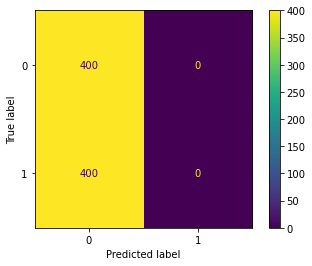


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.25
Macro Recall: 0.50
Macro F1-score: 0.33

Weighted Precision: 0.25
Weighted Recall: 0.50
Weighted F1-score: 0.33

Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       400
           1       0.00      0.00      0.00       400

    accuracy                           0.50       800
   macro avg       0.25      0.50      0.33       800
weighted avg       0.25      0.50      0.33       800

[Epoch 0]: Evaluation accuracy of training: 0.5000000
[Epoch 0]: Evaluation accuracy of validation: 0.5000000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 0, 0, 0])


C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:124

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

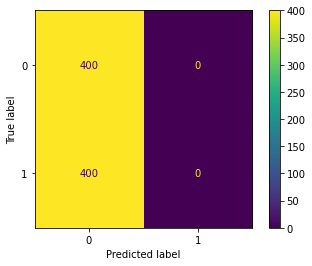


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.25
Macro Recall: 0.50
Macro F1-score: 0.33

Weighted Precision: 0.25
Weighted Recall: 0.50
Weighted F1-score: 0.33

Classification Report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       400
           1       0.00      0.00      0.00       400

    accuracy                           0.50       800
   macro avg       0.25      0.50      0.33       800
weighted avg       0.25      0.50      0.33       800

[Epoch 50]: Evaluation accuracy of training: 0.5000000
[Epoch 50]: Evaluation accuracy of validation: 0.5000000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 0, 0, 0])


C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gouth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:124

[1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0
 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0
 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1
 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1
 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0
 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0
 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0
 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1
 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1
 1 0 1 0 1 1 1 0 1 0 1 0 

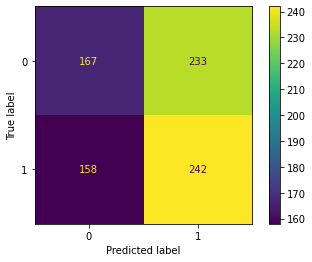


Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.51
Macro Recall: 0.51
Macro F1-score: 0.51

Weighted Precision: 0.51
Weighted Recall: 0.51
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

           0       0.51      0.42      0.46       400
           1       0.51      0.60      0.55       400

    accuracy                           0.51       800
   macro avg       0.51      0.51      0.51       800
weighted avg       0.51      0.51      0.51       800

[Epoch 100]: Evaluation accuracy of training: 0.5125000
[Epoch 100]: Evaluation accuracy of validation: 0.5112500
Labels of trained nodes: 
 tensor([1, 0, 0,  ..., 0, 0, 1])
[1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0
 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0

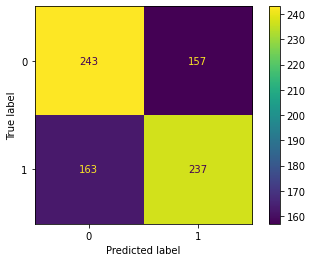


Accuracy: 0.60

Micro Precision: 0.60
Micro Recall: 0.60
Micro F1-score: 0.60

Macro Precision: 0.60
Macro Recall: 0.60
Macro F1-score: 0.60

Weighted Precision: 0.60
Weighted Recall: 0.60
Weighted F1-score: 0.60

Classification Report

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       400
           1       0.60      0.59      0.60       400

    accuracy                           0.60       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.60      0.60      0.60       800

[Epoch 150]: Evaluation accuracy of training: 0.6215625
[Epoch 150]: Evaluation accuracy of validation: 0.6000000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 0, 0, 1])
[1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0
 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0

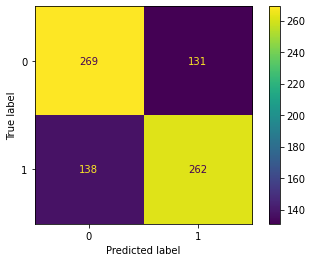


Accuracy: 0.66

Micro Precision: 0.66
Micro Recall: 0.66
Micro F1-score: 0.66

Macro Precision: 0.66
Macro Recall: 0.66
Macro F1-score: 0.66

Weighted Precision: 0.66
Weighted Recall: 0.66
Weighted F1-score: 0.66

Classification Report

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       400
           1       0.67      0.66      0.66       400

    accuracy                           0.66       800
   macro avg       0.66      0.66      0.66       800
weighted avg       0.66      0.66      0.66       800

[Epoch 200]: Evaluation accuracy of training: 0.6868750
[Epoch 200]: Evaluation accuracy of validation: 0.6637500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 0, 1, 1])
[1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0

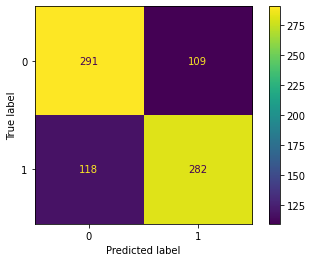


Accuracy: 0.72

Micro Precision: 0.72
Micro Recall: 0.72
Micro F1-score: 0.72

Macro Precision: 0.72
Macro Recall: 0.72
Macro F1-score: 0.72

Weighted Precision: 0.72
Weighted Recall: 0.72
Weighted F1-score: 0.72

Classification Report

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       400
           1       0.72      0.70      0.71       400

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800

[Epoch 250]: Evaluation accuracy of training: 0.7478125
[Epoch 250]: Evaluation accuracy of validation: 0.7162500
Labels of trained nodes: 
 tensor([0, 1, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0

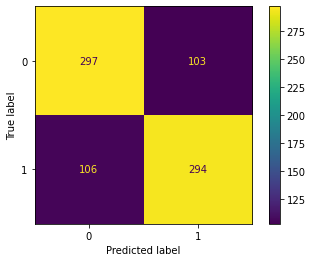


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       400
           1       0.74      0.73      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 300]: Evaluation accuracy of training: 0.7843750
[Epoch 300]: Evaluation accuracy of validation: 0.7387500
Labels of trained nodes: 
 tensor([0, 1, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0

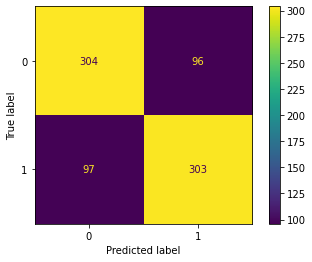


Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.76
Macro Recall: 0.76
Macro F1-score: 0.76

Weighted Precision: 0.76
Weighted Recall: 0.76
Weighted F1-score: 0.76

Classification Report

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       400
           1       0.76      0.76      0.76       400

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800

[Epoch 350]: Evaluation accuracy of training: 0.8109375
[Epoch 350]: Evaluation accuracy of validation: 0.7587500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0

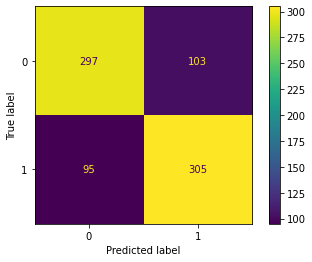


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1-score: 0.75

Macro Precision: 0.75
Macro Recall: 0.75
Macro F1-score: 0.75

Weighted Precision: 0.75
Weighted Recall: 0.75
Weighted F1-score: 0.75

Classification Report

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       400
           1       0.75      0.76      0.75       400

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800

[Epoch 400]: Evaluation accuracy of training: 0.8334375
[Epoch 400]: Evaluation accuracy of validation: 0.7525000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

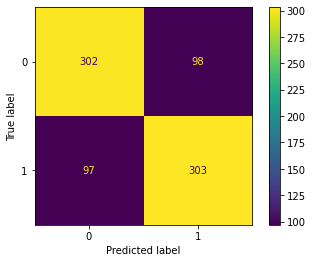


Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.76
Macro Recall: 0.76
Macro F1-score: 0.76

Weighted Precision: 0.76
Weighted Recall: 0.76
Weighted F1-score: 0.76

Classification Report

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       400
           1       0.76      0.76      0.76       400

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800

[Epoch 450]: Evaluation accuracy of training: 0.8518750
[Epoch 450]: Evaluation accuracy of validation: 0.7562500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

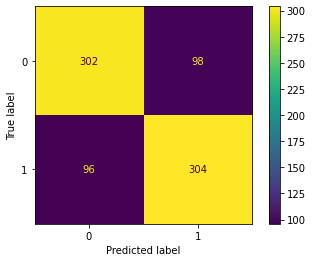


Accuracy: 0.76

Micro Precision: 0.76
Micro Recall: 0.76
Micro F1-score: 0.76

Macro Precision: 0.76
Macro Recall: 0.76
Macro F1-score: 0.76

Weighted Precision: 0.76
Weighted Recall: 0.76
Weighted F1-score: 0.76

Classification Report

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       400
           1       0.76      0.76      0.76       400

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800

[Epoch 500]: Evaluation accuracy of training: 0.8696875
[Epoch 500]: Evaluation accuracy of validation: 0.7575000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

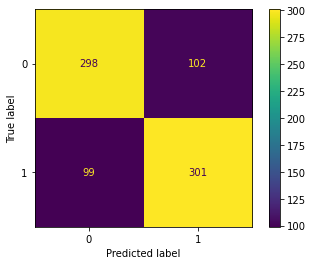


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1-score: 0.75

Macro Precision: 0.75
Macro Recall: 0.75
Macro F1-score: 0.75

Weighted Precision: 0.75
Weighted Recall: 0.75
Weighted F1-score: 0.75

Classification Report

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       400
           1       0.75      0.75      0.75       400

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800

[Epoch 550]: Evaluation accuracy of training: 0.8843750
[Epoch 550]: Evaluation accuracy of validation: 0.7487500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

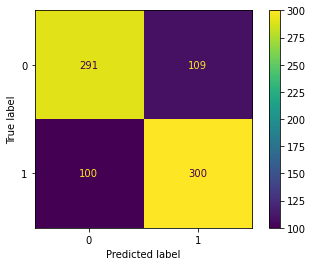


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       400
           1       0.73      0.75      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 600]: Evaluation accuracy of training: 0.8950000
[Epoch 600]: Evaluation accuracy of validation: 0.7387500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

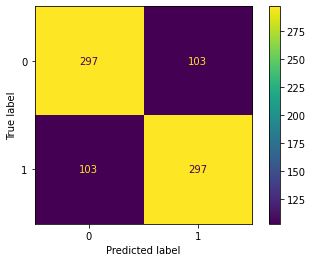


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       400
           1       0.74      0.74      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 650]: Evaluation accuracy of training: 0.9065625
[Epoch 650]: Evaluation accuracy of validation: 0.7425000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

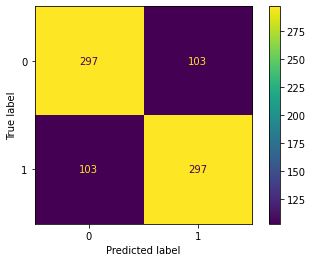


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       400
           1       0.74      0.74      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 700]: Evaluation accuracy of training: 0.9165625
[Epoch 700]: Evaluation accuracy of validation: 0.7425000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

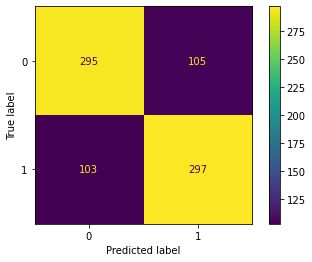


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       400
           1       0.74      0.74      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 750]: Evaluation accuracy of training: 0.9268750
[Epoch 750]: Evaluation accuracy of validation: 0.7400000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

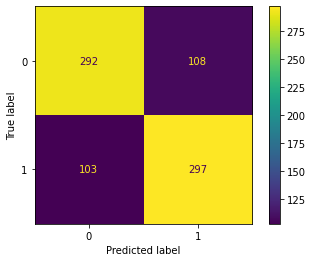


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       400
           1       0.73      0.74      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 800]: Evaluation accuracy of training: 0.9303125
[Epoch 800]: Evaluation accuracy of validation: 0.7362500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

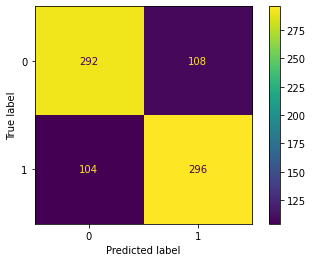


Accuracy: 0.73

Micro Precision: 0.73
Micro Recall: 0.73
Micro F1-score: 0.73

Macro Precision: 0.74
Macro Recall: 0.73
Macro F1-score: 0.73

Weighted Precision: 0.74
Weighted Recall: 0.73
Weighted F1-score: 0.73

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       400
           1       0.73      0.74      0.74       400

    accuracy                           0.73       800
   macro avg       0.74      0.73      0.73       800
weighted avg       0.74      0.73      0.73       800

[Epoch 850]: Evaluation accuracy of training: 0.9381250
[Epoch 850]: Evaluation accuracy of validation: 0.7350000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

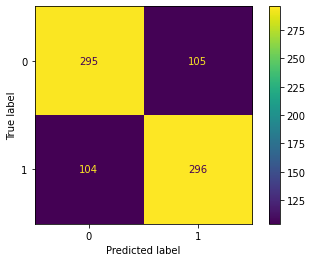


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       400
           1       0.74      0.74      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 900]: Evaluation accuracy of training: 0.9431250
[Epoch 900]: Evaluation accuracy of validation: 0.7387500
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

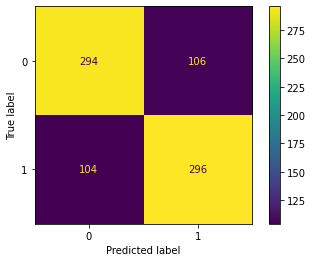


Accuracy: 0.74

Micro Precision: 0.74
Micro Recall: 0.74
Micro F1-score: 0.74

Macro Precision: 0.74
Macro Recall: 0.74
Macro F1-score: 0.74

Weighted Precision: 0.74
Weighted Recall: 0.74
Weighted F1-score: 0.74

Classification Report

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       400
           1       0.74      0.74      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800

[Epoch 950]: Evaluation accuracy of training: 0.9490625
[Epoch 950]: Evaluation accuracy of validation: 0.7375000
Labels of trained nodes: 
 tensor([0, 0, 0,  ..., 1, 1, 1])
Finished training!


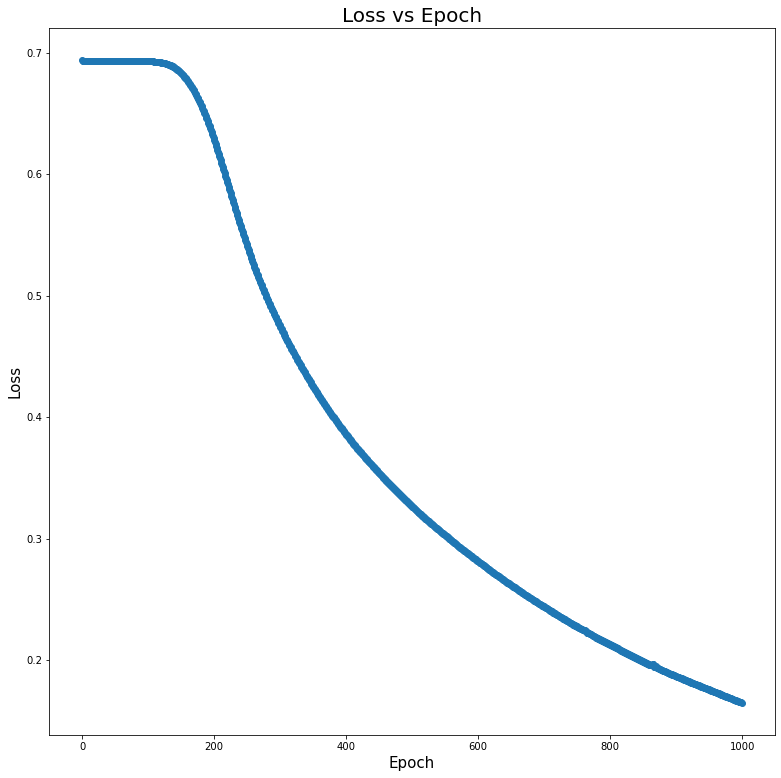

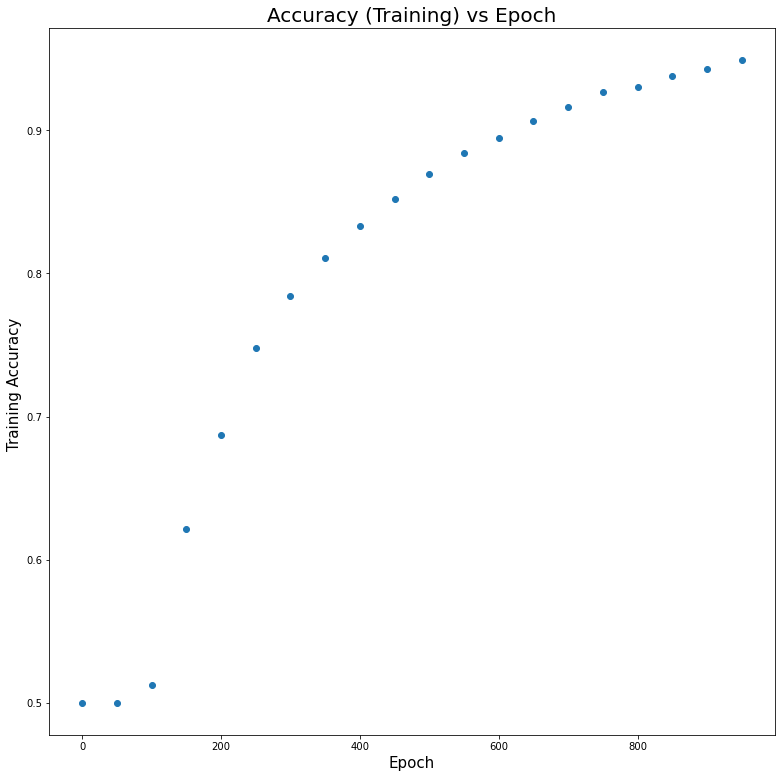

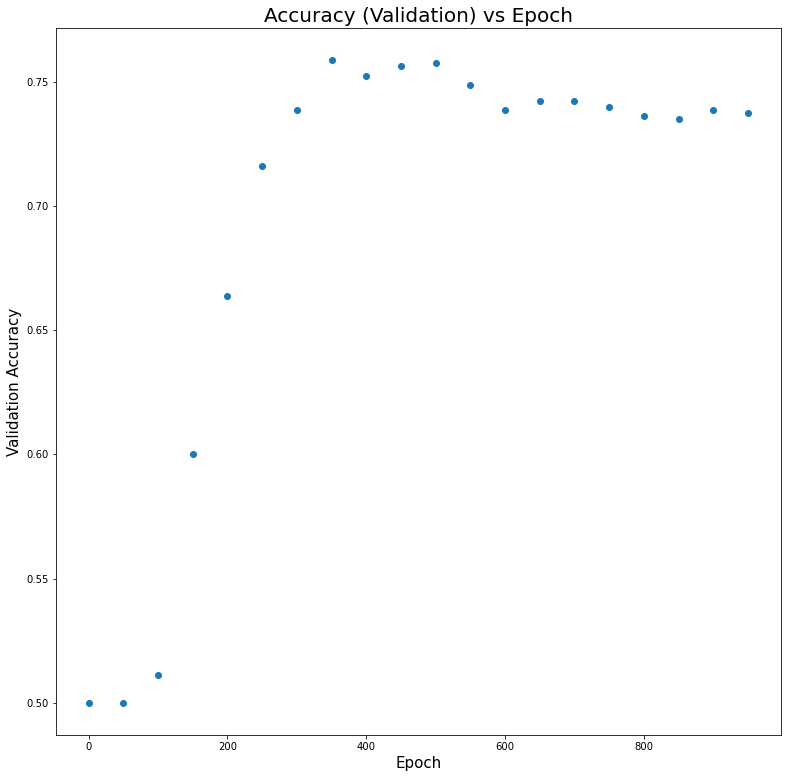

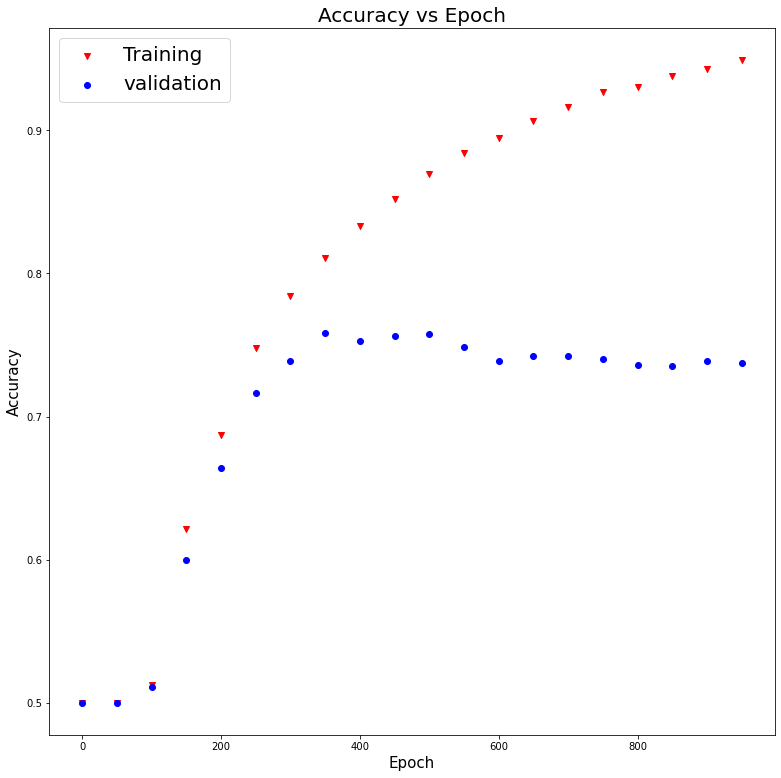

In [13]:
if __name__ == "__main__":
    main()